# Toy COAWST InWave Setup
### This notebook builds the skeleton for defining initial conditions, boundary conditions, and grid parameters for a COAWST InWave model representing the USACE CHL 10m flume. 

In [6]:
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import netCDF4 as netCDF
from datetime import datetime

## Grid

Generate bathymetry.

In [11]:
# convert USACE measurements from feet to meters
ft2m = 1./.3048
Lx = 195.55/ft2m # overall length of flume
Ly = 3 # m

#DX = 0.25 # m; grid cell size in xi direction; uniform grid
#DY = 0.25 # m; grid cell size in eta direction; uniform grid
DX = 0.5 # m; grid cell size in xi direction; uniform grid
DY = 0.5 # m; grid cell size in eta direction; uniform grid

Lpt1 = 11.11/ft2m # transition from flat to initial slope
Lpt2 = (11.11+66.70)/ft2m # transition from initial slope to second flat
Lpt3 = Lpt2
#Lpt3 = 28 # first third of glass window section
#Lpt3 = (115.41+48/3)/ft2m # first third of glass window section

slope1 = (1/ft2m)/(43.5/ft2m) # initial slope
slope2 = 1/35
#slope2 = 1/20

Lp= round(Lx/DX)       # number of total rho points in the xi direction
Mp= round(Ly/DY)       # number of total rho points in the eta direction

X = np.arange(0, DX*(Lp), DX)
Y = np.arange(0, DY*(Mp), DY)

In [12]:
depth = np.zeros_like(X)

ind1 = np.argwhere((X>=(Lpt1-DX/2)) & (X<(Lpt1+DX/2)))
ind2 = np.argwhere((X>=(Lpt2-DX/2)) & (X<(Lpt2+DX/2)))
ind3 = np.argwhere((X>=(Lpt3-DX/2)) & (X<(Lpt3+DX/2)))

for ind in range(len(depth)-1):
    if (ind >= ind1) and (ind < ind2):
        depth[ind+1] = depth[ind]+(DX*slope1)
    elif (ind >= ind2) and (ind < ind3):
        depth[ind+1] = depth[ind]
    elif (ind >= ind3):
        depth[ind+1] = depth[ind]+(DX*slope2)

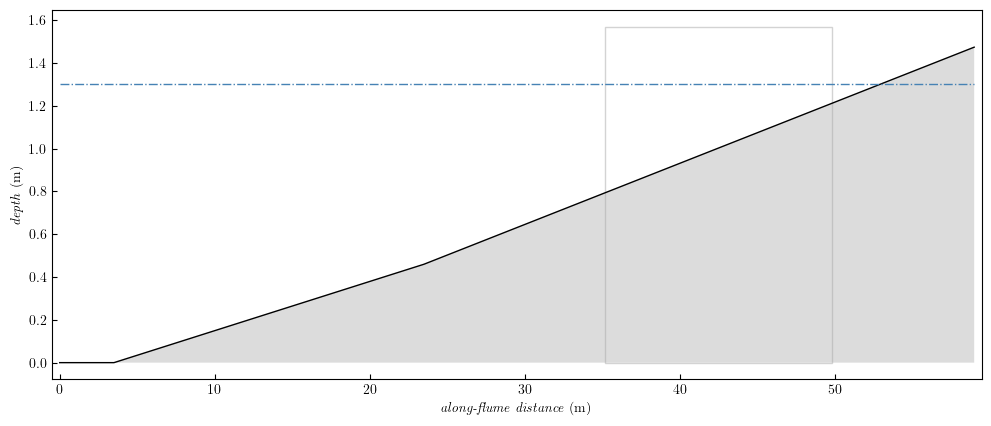

In [13]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax = plt.subplots(1)
ax.plot(X,depth,'-', color='k', lw=1)
ax.plot(X, np.ones_like(X)*1.3, '-.', color='steelblue', lw=1)
ax.fill_between(X, np.zeros_like(X), depth, facecolor='gainsboro', edgecolor='None')

# define corner points
glassx = [115.41/ft2m, (115.41+48)/ft2m, (115.41+48)/ft2m, 115.41/ft2m]
glassy = [0, 0, 1.57, 1.57]
ax.fill(glassx,glassy, edgecolor='darkgray', facecolor='None', alpha=.5)

ax.set_xlim([-0.5, 59.5])
#ax.set_ylim([-0.03, 1.6])
ax.set_xlabel(r'\textit{along-flume distance} (m)')
ax.set_ylabel(r'\textit{depth} (m)')
ax.tick_params(direction="in")
fig.set_figwidth(12)

fig.savefig('sedcolab_bathy_1on35_contslope_0p5res', dpi=350)

In [14]:
with open("sedcolab_1on35cont.bot", "w") as file:
    for dat in depth[0::2]:
        file.write('%0.2f ' % (1.3-dat))
        file.write('\n')

Generate netcdf grid file. 

Need to define:
1) grid name
2) x, y, dx, dy
3) depth
4) angle
5) mask
6) f, Coriolis parameter
7) spherical, F for Cartesian grid

In [9]:
grd_file = 'InWave_sedcolab_grd.nc'

# X, Y, dx, dy defined above
[x,y] = np.meshgrid(X,Y)
x = x.transpose()
y = y.transpose()

[dx,dy] = np.meshgrid(np.ones_like(X)*DX,np.ones_like(Y)*DY)
dx = dx.transpose()
dy = dy.transpose()
 
#roms_depth = np.ones_like(x)*(1.3-depth[:, np.newaxis])
roms_depth = np.ones_like(x)*(-depth[:, np.newaxis])

roms_angle = np.zeros_like(roms_depth)

mask_rho = np.ones_like(roms_depth)

f = np.zeros_like(roms_depth)

spherical = 'F'

In [16]:
with open("sedcolab.bot", "w") as file:
    for dat in roms_depth[0::2,4]:
        file.write('%0.2f ' % dat)
        file.write('\n')

## Waves

In [69]:
wave_depth = 1.3+roms_depth
TA = 2.25 # representative absolute wave period (s)
theta = 270

# calculate wavenumber
L0 = (9.81*TA**2)/(2*np.pi)
L = np.zeros_like(wave_depth)
for nn in range(100):
    L = L0*np.tanh((wave_depth*2*np.pi)/L)
    
k = (2*np.pi)/L

# calculate wave celerity
C = L/TA

# calculate wave group celerity
Cg = (C*0.5)*(1+((k*2)*wave_depth)/np.sinh((k*2)*wave_depth))

/var/folders/hl/l_pnglm51ys884gjlrjhkgqm0000gn/T/ipykernel_55364/1208009135.py:9: RuntimeWarning: divide by zero encountered in divide
  L = L0*np.tanh((wave_depth*2*np.pi)/L)


## Initial conditions

In [70]:
ini_file = 'InWave_sedcolab_ini.nc'

Nbins = 1 # number of directional bins
Bindirs_centers = 270

Ac = np.zeros((Lp, Mp, Nbins))
Cx = np.zeros((Lp-1, Mp, Nbins))
Cy = np.zeros((Lp, Mp-1, Nbins))
Ct = np.zeros((Lp, Mp, Nbins+1))

## Boundary conditions

In [83]:
bry_file = 'InWave_sedcolab_bry.nc'

dt = 0.2 # temporal resolution for the BCs (s)
drtn = 600 # total duration of the simulation (s)

time = np.arange(0, drtn, dt)

# boundary condition specification
# N E S W
obc = [0, 0, 0, 1]

Nbins_bnd = 3 # number of directions at the boundaries (have to choose at least 2)
dir_bnd = np.arange(269,272,1) # center angle(s)
dind = np.argwhere(dir_bnd == theta)

# bichromatic waves

a1=0.05
a2=0.05
f1=0.4
T1=1/f1
f2=0.5
T2=1/f2
Tm=(T1+T2)/2
TA=Tm

if obc[3] == 1:
    Ac_west = np.zeros((Mp, Nbins_bnd, len(time)))
    eta = a1*np.cos(2*np.pi*f1*time) + a2*np.cos(2*np.pi*f2*time)
    eta_hil = hilbert(eta)
    amp_hil = np.abs(eta_hil)
    energy = (1/2)*1025*9.81*amp_hil**2 #(J/m2)
    Ac1 = energy*TA/(2*np.pi)
    for ii in range(Mp):
        Ac_west[ii, dind[0][0], :] = Ac1
    TA_west = TA
    
print(TA)

2.25


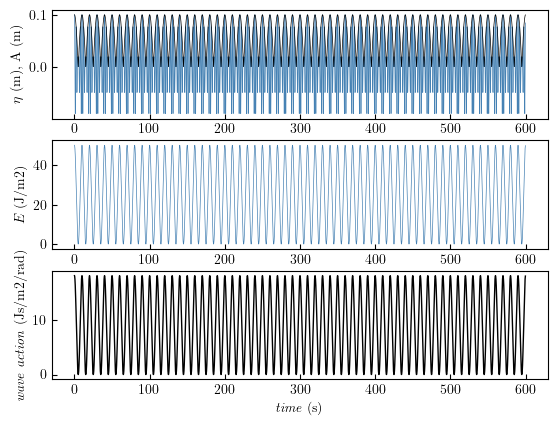

In [84]:
fig, ax = plt.subplots(3)
ax[0].plot(time, eta, '-', color='steelblue', lw=0.5)
ax[0].plot(time, amp_hil, '-', color='black', lw=0.5)
ax[0].set_ylabel(r'\textit{$\eta$} (m), A (m)')
ax[0].tick_params(direction="in")

ax[1].plot(time, energy, '-', color='steelblue', lw=0.5)
ax[1].set_ylabel(r'\textit{$E$} (J/m2)')
ax[1].tick_params(direction="in")

ax[2].plot(time, Ac_west[1, dind[0][0], :],'-', color='k', lw=1)
ax[2].set_xlabel(r'\textit{time} (s)')
ax[2].set_ylabel(r'\textit{wave action} (Js/m2/rad)')
ax[2].tick_params(direction="in")

Now actually create the netcdf grid, initial, and boundary files

In [75]:
# Create InWave initial condition file
nc = netCDF.Dataset(ini_file, 'w', format='NETCDF4')
nc.Description = 'INITIAL file for the InWave model'
nc.Author = 'pyroms_toolbox.nc_create_roms_file'
nc.Created = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
nc.title = 'InWave'

L = Lp-1
M = Mp-1
initime = 0

nc.createDimension('xpsi', L)
nc.createDimension('xrho', Lp)
nc.createDimension('xu', L)
nc.createDimension('xv', Lp)

nc.createDimension('epsi', M)
nc.createDimension('erho', Mp)
nc.createDimension('eu', Mp)
nc.createDimension('ev', M)

nc.createDimension('energy_time', 1)
nc.createDimension('energy_angle_centers', Nbins)
nc.createDimension('ND', Nbins)
nc.createDimension('energy_angle_faces', Nbins+1)
nc.createDimension('TA_dim', 1)

nc.createVariable('energy_time', 'f8', ('energy_time'))
nc.variables['energy_time'].long_name = 'time for energy envelope'
nc.variables['energy_time'].units = 'seconds'
nc.variables['energy_time'].field = 'energy_time, scalar, series'
nc.variables['energy_time'][:] = initime

nc.createVariable('energy_angle', 'f8', ('energy_angle_centers'))
nc.variables['energy_angle'].long_name = 'direction with respect to the north of the bin'
nc.variables['energy_angle'].units = 'degrees'
nc.variables['energy_angle'].field = 'energy_angle, scalar, series'
nc.variables['energy_angle'][:] = Bindirs_centers

nc.createVariable('TA_dim', 'f8', ('TA_dim'))
nc.variables['TA_dim'].long_name = 'representative absolute peak period'
nc.variables['TA_dim'].units = 'seconds'
nc.variables['TA_dim'].field = 'TA_dim, scalar, series'
nc.variables['TA_dim'][:] = 1

nc.createVariable('AC', 'f8', ('energy_angle_centers', 'erho', 'xrho'))
nc.variables['AC'].long_name = 'wave action envelope'
nc.variables['AC'].units = 'Joules s m-2 rad-1'
nc.variables['AC'].field = 'AC, scalar, series'
nc.variables['AC'][:] = Ac.transpose((2,1,0))

nc.createVariable('Cx', 'f8', ('energy_angle_centers', 'erho', 'xu'))
nc.variables['Cx'].long_name = 'x-component of the wave group celerity'
nc.variables['Cx'].units = 'm s-1'
nc.variables['Cx'].field = 'cx, scalar, series'
nc.variables['Cx'][:] = Cx.transpose((2,1,0))

nc.createVariable('Cy', 'f8', ('energy_angle_centers', 'ev', 'xrho'))
nc.variables['Cy'].long_name = 'y-component of the wave group celerity'
nc.variables['Cy'].units = 'm s-1'
nc.variables['Cy'].field = 'cy, scalar, series'
nc.variables['Cy'][:] = Cy.transpose((2,1,0))

nc.createVariable('Ct', 'f8', ('energy_angle_faces', 'erho', 'xrho'))
nc.variables['Ct'].long_name = 'directional component of the wave group celerity'
nc.variables['Ct'].units = 'rad s-1'
nc.variables['Ct'].field = 'ct, scalar, series'
nc.variables['Ct'][:] = Ct.transpose((2,1,0))

nc.createVariable('Ta', 'f8', ('energy_angle_centers', 'erho', 'xrho'))
nc.variables['Ta'].long_name = 'representative absolute peak period'
nc.variables['Ta'].units = 'seconds'
nc.variables['Ta'].field = 'Ta, scalar, series'
nc.variables['Ta'][:] = np.ones_like(Ac.transpose((2,1,0)))*TA

nc.close()

In [85]:
# Create InWave boundary condition file
nc = netCDF.Dataset(bry_file, 'w', format='NETCDF4')
nc.Description = 'BOUNDARY file for the InWave model'
nc.Author = 'pyroms_toolbox.nc_create_roms_file'
nc.Created = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
nc.title = 'InWave'

L = Lp-1
M = Mp-1

NT = len(time)

nc.createDimension('xpsi', L)
nc.createDimension('xrho', Lp)
nc.createDimension('xu', L)
nc.createDimension('xv', Lp)

nc.createDimension('epsi', M)
nc.createDimension('erho', Mp)
nc.createDimension('eu', Mp)
nc.createDimension('ev', M)

nc.createDimension('energy_time', NT)
nc.createDimension('energy_angle_c', Nbins_bnd)
nc.createDimension('energy_angle', Nbins_bnd)
nc.createDimension('TA_dim', 1)

nc.createVariable('energy_time', 'f8', ('energy_time'))
nc.variables['energy_time'].long_name = 'time for energy envelope'
nc.variables['energy_time'].units = 'seconds'
nc.variables['energy_time'].field = 'energy_time, scalar, series'
nc.variables['energy_time'][:] = time

nc.createVariable('energy_angle_c', 'f8', ('energy_angle'))
nc.variables['energy_angle_c'].long_name = 'direction with respect to the north of the bin'
nc.variables['energy_angle_c'].units = 'degrees'
nc.variables['energy_angle_c'].field = 'energy_angle, scalar, series'
nc.variables['energy_angle_c'][:] = dir_bnd

#nc.createVariable('energy_angle', 'f8', ('energy_angle'))
#nc.variables['energy_angle'].long_name = 'direction with respect to the north of the bin'
#nc.variables['energy_angle'].units = 'degrees'
#nc.variables['energy_angle'].field = 'energy_angle, scalar, series'
#nc.variables['energy_angle'][:] = dir_bnd

nc.createVariable('TA_dim', 'f8', ('TA_dim'))
nc.variables['TA_dim'].long_name = 'representative absolute peak period'
nc.variables['TA_dim'].units = 'seconds'
nc.variables['TA_dim'].field = 'TA_dim, scalar, series'
nc.variables['TA_dim'][:] = 1

nc.createVariable('AC_west', 'f8', ('energy_time', 'energy_angle', 'erho'))
nc.variables['AC_west'].long_name = 'western boundary wave action envelope'
nc.variables['AC_west'].units = 'Joules s m-2 rad-1'
nc.variables['AC_west'].field = 'AC, scalar, series'
nc.variables['AC_west'][:] = Ac_west.transpose((2, 1, 0))

nc.createVariable('Ta_west', 'f8', ('TA_dim'))
nc.variables['Ta_west'].long_name = 'western boundary representative absolute peak period'
nc.variables['Ta_west'].units = 'seconds'
nc.variables['Ta_west'].field = 'Ta, scalar, series'
nc.variables['Ta_west'][:] = TA

nc.close()

In [79]:
# Create InWave grid file
nc = netCDF.Dataset(grd_file, 'w', format='NETCDF4')
nc.Description = 'ROMS grid file'
nc.Author = 'pyroms_toolbox.nc_create_roms_file'
nc.Created = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
nc.title = 'ROMS Application'

L = Lp-1
Lm = L-1
M = Mp-1
Mm = M-1

# Create higher resolution grid for psi, u, and v points
GRID_X = np.arange(np.min(x), np.max(x)+DX/2, DX/2)
GRID_Y = np.arange(np.min(y), np.max(y)+DY/2, DY/2)
[grid_x,grid_y] = np.meshgrid(GRID_X,GRID_Y)
grid_x = grid_x.transpose()
grid_y = grid_y.transpose()

NT = len(time)
xl = np.max(x[:])-np.min(x[:])
el = np.max(y[:])-np.min(y[:])

nc.createDimension('xi_psi', L)
nc.createDimension('xi_rho', Lp)
nc.createDimension('xi_u', L)
nc.createDimension('xi_v', Lp)

nc.createDimension('eta_psi', M)
nc.createDimension('eta_rho', Mp)
nc.createDimension('eta_u', Mp)
nc.createDimension('eta_v', M)

nc.createDimension('one', 1) # not sure what is going on here...
nc.createDimension('two', 2)
nc.createDimension('bath', 1)

nc.createVariable('xl', 'f8', ('one'))
nc.variables['xl'].long_name = 'domain length in the XI-direction'
nc.variables['xl'].units = 'meter'
nc.variables['xl'][:] = xl

nc.createVariable('el', 'f8', ('one'))
nc.variables['el'].long_name = 'domain length in the ETA-direction'
nc.variables['el'].units = 'meter'
nc.variables['el'][:] = el

nc.createVariable('JPRJ', 'S1', ('two'))
nc.variables['JPRJ'].long_name = 'Map projection type'
nc.variables['JPRJ'].option_ME = 'Mercator'
nc.variables['JPRJ'].option_ST = 'Stereographic'
nc.variables['JPRJ'].option_LC = 'Lambert conformal conic'
## figure this one out

nc.createVariable('spherical', 'S1', ('one'))
nc.variables['spherical'].long_name = 'Grid type logical switch'
nc.variables['spherical'].option_T = 'spherical'
nc.variables['spherical'].option_F = 'Cartesian'
nc.variables['spherical'][:] = spherical

nc.createVariable('depthmin', 'i2', ('one'))
nc.variables['depthmin'].long_name = 'shallow bathymetry allowable depth'
nc.variables['depthmin'].units = 'meter'
nc.variables['depthmin'][:] = -5 # following lip

nc.createVariable('depthmax', 'i2', ('one'))
nc.variables['depthmax'].long_name = 'deep bathymetry allowable depth'
nc.variables['depthmax'].units = 'meter'
nc.variables['depthmax'][:] = 0

nc.createVariable('hraw', 'f8', ('bath', 'eta_rho', 'xi_rho'))
nc.variables['hraw'].long_name = 'working bathymetry at RHO-points'
nc.variables['hraw'].units = 'meter'
nc.variables['hraw'].field = 'bath, scalar'
nc.variables['hraw'][:] = roms_depth[..., np.newaxis].transpose((2, 1, 0))

nc.createVariable('h', 'f8', ('eta_rho', 'xi_rho'))
nc.variables['h'].long_name = 'final bathymetry at RHO-points'
nc.variables['h'].units = 'meter'
nc.variables['h'].field = 'bath, scalar'
nc.variables['h'][:] = roms_depth.T

nc.createVariable('f', 'f8', ('eta_rho', 'xi_rho'))
nc.variables['f'].long_name = 'Coriolis parameter at RHO-points'
nc.variables['f'].units = 'second-1'
nc.variables['f'].field = 'Coriolis, scalar'
nc.variables['f'][:] = f.T

nc.createVariable('pm', 'f8', ('eta_rho', 'xi_rho'))
nc.variables['pm'].long_name = 'curvilinear coordinate metric in XI'
nc.variables['pm'].units = 'meter-1'
nc.variables['pm'].field = 'pm, scalar'
nc.variables['pm'][:] = 1/dx.T

nc.createVariable('pn', 'f8', ('eta_rho', 'xi_rho'))
nc.variables['pn'].long_name = 'curvilinear coordinate metric in ETA'
nc.variables['pn'].units = 'meter-1'
nc.variables['pn'].field = 'pm, scalar'
nc.variables['pn'][:] = 1/dy.T

nc.createVariable('dndx', 'f8', ('eta_rho', 'xi_rho'))
nc.variables['dndx'].long_name = 'xi derivative of inverse metric factor pn'
nc.variables['dndx'].units = 'meter'
nc.variables['dndx'].field = 'dndx, scalar'
nc.variables['dndx'][:] = np.zeros_like(dx).T

nc.createVariable('dmde', 'f8', ('eta_rho', 'xi_rho'))
nc.variables['dmde'].long_name = 'eta derivative of inverse metric factor pm'
nc.variables['dmde'].units = 'meter'
nc.variables['dmde'].field = 'dmde, scalar'
nc.variables['dmde'][:] = np.zeros_like(dx).T

nc.createVariable('x_rho', 'f8', ('eta_rho', 'xi_rho'))
nc.variables['x_rho'].long_name = 'x location of RHO-points'
nc.variables['x_rho'].units = 'meter'
nc.variables['x_rho'][:] = x.T

nc.createVariable('y_rho', 'f8', ('eta_rho', 'xi_rho'))
nc.variables['y_rho'].long_name = 'y location of RHO-points'
nc.variables['y_rho'].units = 'meter'
nc.variables['y_rho'][:] = y.T

nc.createVariable('x_psi', 'f8', ('eta_psi', 'xi_psi'))
nc.variables['x_psi'].long_name = 'x location of PSI-points'
nc.variables['x_psi'].units = 'meter'
nc.variables['x_psi'][:] = grid_x[1::2,1::2].T

nc.createVariable('y_psi', 'f8', ('eta_psi', 'xi_psi'))
nc.variables['y_psi'].long_name = 'y location of PSI-points'
nc.variables['y_psi'].units = 'meter'
nc.variables['y_psi'][:] = grid_y[1::2,1::2].T

nc.createVariable('x_u', 'f8', ('eta_u', 'xi_u'))
nc.variables['x_u'].long_name = 'x location of U-points'
nc.variables['x_u'].units = 'meter'
nc.variables['x_u'][:] = grid_x[1::2,0::2].T

nc.createVariable('y_u', 'f8', ('eta_u', 'xi_u'))
nc.variables['y_u'].long_name = 'y location of U-points'
nc.variables['y_u'].units = 'meter'
nc.variables['y_u'][:] = grid_y[1::2,0::2].T

nc.createVariable('x_v', 'f8', ('eta_v', 'xi_v'))
nc.variables['x_v'].long_name = 'x location of V-points'
nc.variables['x_v'].units = 'meter'
nc.variables['x_v'][:] = grid_x[0::2,1::2].T

nc.createVariable('y_v', 'f8', ('eta_v', 'xi_v'))
nc.variables['y_v'].long_name = 'y location of V-points'
nc.variables['y_v'].units = 'meter'
nc.variables['y_v'][:] = grid_y[0::2,1::2].T

nc.createVariable('mask_rho', 'f8', ('eta_rho', 'xi_rho'))
nc.variables['mask_rho'].long_name = 'mask on RHO-points'
nc.variables['mask_rho'].option_0 = 'land'
nc.variables['mask_rho'].option_1 = 'water'
nc.variables['mask_rho'][:] = mask_rho.T

nc.createVariable('mask_u', 'f8', ('eta_u', 'xi_u'))
nc.variables['mask_u'].long_name = 'mask on U-points'
nc.variables['mask_u'].option_0 = 'land'
nc.variables['mask_u'].option_1 = 'water'
nc.variables['mask_u'][:] = np.ones_like(grid_x[1::2,0::2]).T

nc.createVariable('mask_v', 'f8', ('eta_v', 'xi_v'))
nc.variables['mask_v'].long_name = 'mask on V-points'
nc.variables['mask_v'].option_0 = 'land'
nc.variables['mask_v'].option_1 = 'water'
nc.variables['mask_v'][:] = np.ones_like(grid_x[0::2,1::2]).T

nc.createVariable('mask_psi', 'f8', ('eta_psi', 'xi_psi'))
nc.variables['mask_psi'].long_name = 'mask on PSI-points'
nc.variables['mask_psi'].option_0 = 'land'
nc.variables['mask_psi'].option_1 = 'water'
nc.variables['mask_psi'][:] = np.ones_like(grid_x[1::2,1::2]).T

nc.createVariable('angle', 'f8', ('eta_rho', 'xi_rho'))
nc.variables['angle'].long_name = 'angle between xi axis and east'
nc.variables['angle'].units = 'degree'
nc.variables['angle'][:] = roms_angle.T

nc.close()